# CNN-VAE on HUTUBS dataset (Chen et al. 2019)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from IPython.display import display
from pysofaconventions import *

from utils_data import load_hutubs_yamo
from utils_model_1d import create_autoencoder_dense, create_autoencoder_resnet, create_autoencoder_inception, \
                           create_cvae_dense, create_cvae_resnet, create_cvae_inception
from utils_train import train_model
from utils_plot import plot_reconstructions_chen2019, plot_reconstructions_cvae, \
                       plot_xcorr, plot_xcorr_cvae, plot_latent_space

In [4]:
## some useful functions
def normalize_hrtf(hrtf, x_mean, x_std):
    hrtf_n = hrtf.copy()
    hrtf_n -= x_mean
    hrtf_n /= x_std
    return hrtf_n

def denormalize_hrtf(hrtf, x_mean, x_std):
    hrtf_n = hrtf.copy()
    hrtf_n *= x_std
    hrtf_n += x_mean
    return hrtf_n

## Load data

In [5]:
# show all possible setups
import scipy.io as sio
azimuths = sio.loadmat('./HRTF data for DL/azimuth.mat')['azimuth'][0]  ## The previous 'azimuth.mat' and 'elevation.mat' are cell arrays, that's not correct. I resaved them as normal arrays. Also, they need to be 1xN arrays.   
elevations = sio.loadmat('./HRTF data for DL/elevation.mat')['elevation'][0]
freqs = sio.loadmat('./HRTF data for DL/freq_matlab.mat')['X'][0]
# print(azimuths) 
# print(elevations)
# print(len(azimuths[::5]) * (len(elevations[::2])-2))

In [6]:
from utils_data import load_hutubs_yamo

# load HRTFs from HUTUBS 
filters = {
    'ears': ['left'],
    #'ids': range(1,31),
    'azimuth': (np.arange(-70,70,2) % 360),
    'elevation': np.arange(-40,40,10)    # elevation reoslution: 10 degrees
}

# print(filters)
(x_train, y_train),(x_test, y_test)=load_hutubs_yamo(
    #dataset_path='./Studienarbeit_test/',
    dataset_path='./HRTF data for DL', 
    anthropometrics_path='./HRTF data for DL/AntrhopometricMeasures.csv', 
    data_content='hrtfs',
    user_filters=filters
)
print(x_train)
# remove neighbors
x_train = x_train[:,3,3,:]
x_test = x_test[:,3,3,:]

{'ids': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96], 'ears': ['left'], 'azimuth': array([290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314,
       316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340,
       342, 344, 346, 348, 350, 352, 354, 356, 358,   0,   2,   4,   6,
         8,  10,  12,  14,  16,  18,  20,  22,  24,  26,  28,  30,  32,
        34,  36,  38,  40,  42,  44,  46,  48,  50,  52,  54,  56,  58,
        60,  62,  64,  66,  68], dtype=int32), 'elevation': array([-40, -30, -20, -10,   0,  10,  20,  30])}
Train/test split: 72/24 ids


  0%|          | 0/53760 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


  0%|          | 59/53760 [00:00<03:02, 294.97it/s]

19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


  0%|          | 138/53760 [00:00<02:29, 358.70it/s]

87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162


  0%|          | 219/53760 [00:00<02:18, 387.26it/s]

163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


  1%|          | 300/53760 [00:00<02:18, 386.64it/s]

71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158


  1%|          | 346/53760 [00:00<02:11, 407.01it/s]

159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


  1%|          | 394/53760 [00:01<02:04, 427.73it/s]

42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


  1%|          | 446/53760 [00:01<01:57, 454.25it/s]

89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145


  1%|          | 499/53760 [00:01<01:52, 474.55it/s]

146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


  1%|          | 594/53760 [00:01<01:53, 468.71it/s]

19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


  1%|          | 643/53760 [00:01<01:52, 470.31it/s]

115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167


  1%|▏         | 695/53760 [00:01<01:49, 482.54it/s]

168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


  1%|▏         | 744/53760 [00:01<01:53, 467.77it/s]

33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


  1%|▏         | 792/53760 [00:01<01:52, 470.93it/s]

85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129


  2%|▏         | 841/53760 [00:01<01:51, 475.02it/s]

130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9


  2%|▏         | 889/53760 [00:02<01:51, 472.75it/s]

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


  2%|▏         | 940/53760 [00:02<01:49, 480.39it/s]

52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


  2%|▏         | 990/53760 [00:02<01:48, 485.76it/s]

111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


  2%|▏         | 1039/53760 [00:02<01:50, 476.15it/s]

148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


  2%|▏         | 1087/53760 [00:02<01:53, 463.55it/s]

27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


  2%|▏         | 1137/53760 [00:02<01:51, 471.76it/s]

65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


  2%|▏         | 1193/53760 [00:02<01:45, 496.34it/s]

138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


  2%|▏         | 1243/53760 [00:02<01:49, 478.88it/s]

171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


  2%|▏         | 1292/53760 [00:02<01:53, 460.82it/s]

58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


  2%|▏         | 1339/53760 [00:03<02:02, 429.64it/s]

78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


  3%|▎         | 1388/53760 [00:03<01:58, 443.74it/s]

138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175


  3%|▎         | 1435/53760 [00:03<01:56, 449.12it/s]

176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


  3%|▎         | 1481/53760 [00:03<02:01, 429.17it/s]

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


  3%|▎         | 1530/53760 [00:03<01:57, 445.18it/s]

92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


  3%|▎         | 1583/53760 [00:03<01:51, 468.75it/s]

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


  3%|▎         | 1631/53760 [00:03<01:56, 447.92it/s]

17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93


  3%|▎         | 1720/53760 [00:03<02:02, 423.22it/s]

94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3


  3%|▎         | 1763/53760 [00:04<02:04, 418.91it/s]

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


  3%|▎         | 1813/53760 [00:04<01:58, 440.17it/s]

53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


  3%|▎         | 1865/53760 [00:04<01:52, 462.75it/s]

106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


  4%|▎         | 1915/53760 [00:04<01:49, 473.27it/s]

156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


  4%|▎         | 1965/53760 [00:04<01:48, 478.64it/s]

30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


  4%|▍         | 2020/53760 [00:04<01:43, 498.57it/s]

83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140


  4%|▍         | 2076/53760 [00:04<01:40, 515.29it/s]

141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8


  4%|▍         | 2128/53760 [00:04<01:43, 499.38it/s]

9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


  4%|▍         | 2181/53760 [00:04<01:41, 507.24it/s]

67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


  4%|▍         | 2232/53760 [00:04<01:47, 477.81it/s]

114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


  4%|▍         | 2281/53760 [00:05<02:01, 425.24it/s]

154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


  4%|▍         | 2325/53760 [00:05<02:28, 346.26it/s]

29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


  4%|▍         | 2363/53760 [00:05<02:34, 332.71it/s]

55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


  4%|▍         | 2399/53760 [00:05<02:39, 322.19it/s]

86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152


  5%|▍         | 2478/53760 [00:05<02:27, 348.58it/s]

153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


  5%|▍         | 2514/53760 [00:05<02:34, 332.38it/s]

45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


  5%|▍         | 2553/53760 [00:05<02:28, 345.80it/s]

88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


  5%|▍         | 2592/53760 [00:06<02:23, 357.42it/s]

120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157


  5%|▍         | 2629/53760 [00:06<02:24, 352.86it/s]

158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13


  5%|▍         | 2667/53760 [00:06<02:21, 360.34it/s]

14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


  5%|▌         | 2706/53760 [00:06<02:19, 366.46it/s]

58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


  5%|▌         | 2743/53760 [00:06<02:20, 362.03it/s]

98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


  5%|▌         | 2780/53760 [00:06<02:22, 357.91it/s]

136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173


  5%|▌         | 2817/53760 [00:06<02:26, 348.62it/s]

174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


  5%|▌         | 2853/53760 [00:06<02:25, 349.15it/s]

33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


  5%|▌         | 2889/53760 [00:06<02:35, 326.19it/s]

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


  5%|▌         | 2931/53760 [00:07<02:24, 351.32it/s]

105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


  6%|▌         | 2978/53760 [00:07<02:12, 382.76it/s]

154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


  6%|▌         | 3020/53760 [00:07<02:09, 392.66it/s]

25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


  6%|▌         | 3104/53760 [00:07<02:07, 398.61it/s]

64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


  6%|▌         | 3154/53760 [00:07<01:58, 426.33it/s]

156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


  6%|▌         | 3200/53760 [00:07<01:56, 435.63it/s]

33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


  6%|▌         | 3244/53760 [00:07<01:56, 433.30it/s]

68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


  6%|▌         | 3294/53760 [00:07<01:51, 451.99it/s]

127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164


  6%|▌         | 3340/53760 [00:07<01:51, 452.52it/s]

165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


  6%|▋         | 3389/53760 [00:08<01:48, 462.58it/s]

46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


  6%|▋         | 3442/53760 [00:08<01:44, 481.57it/s]

90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


  6%|▋         | 3491/53760 [00:08<01:44, 480.15it/s]

148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10


  7%|▋         | 3540/53760 [00:08<01:44, 480.60it/s]

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


  7%|▋         | 3596/53760 [00:08<01:40, 501.61it/s]

77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123


  7%|▋         | 3707/53760 [00:08<01:36, 516.89it/s]

124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


  7%|▋         | 3759/53760 [00:08<01:39, 503.42it/s]

56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


  7%|▋         | 3810/53760 [00:08<01:42, 487.36it/s]

113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148


  7%|▋         | 3859/53760 [00:09<01:52, 442.43it/s]

149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11


  7%|▋         | 3905/53760 [00:09<01:57, 422.93it/s]

12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


  7%|▋         | 3958/53760 [00:09<01:50, 449.27it/s]

58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


  7%|▋         | 4009/53760 [00:09<01:47, 464.87it/s]

122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162


  8%|▊         | 4057/53760 [00:09<01:57, 422.08it/s]

163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


  8%|▊         | 4101/53760 [00:09<02:04, 397.61it/s]

46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


  8%|▊         | 4153/53760 [00:09<01:55, 428.89it/s]

90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


  8%|▊         | 4208/53760 [00:09<01:47, 460.74it/s]

150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


  8%|▊         | 4256/53760 [00:09<01:47, 461.15it/s]

18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


  8%|▊         | 4311/53760 [00:10<01:41, 485.32it/s]

76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


  8%|▊         | 4366/53760 [00:10<01:38, 502.58it/s]

127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6


  8%|▊         | 4418/53760 [00:10<01:37, 505.34it/s]

7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


  8%|▊         | 4476/53760 [00:10<01:33, 524.81it/s]

59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


  8%|▊         | 4535/53760 [00:10<01:30, 542.83it/s]

131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


  9%|▊         | 4590/53760 [00:10<01:33, 526.38it/s]

175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


  9%|▊         | 4646/53760 [00:10<01:31, 535.76it/s]

61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


  9%|▊         | 4700/53760 [00:10<01:45, 466.32it/s]

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163


  9%|▉         | 4749/53760 [00:10<02:03, 395.93it/s]

164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


  9%|▉         | 4830/53760 [00:11<02:21, 346.54it/s]

41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


  9%|▉         | 4867/53760 [00:11<02:25, 335.25it/s]

107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


  9%|▉         | 4902/53760 [00:11<02:30, 325.16it/s]

148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


  9%|▉         | 4936/53760 [00:11<02:34, 315.44it/s]

167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


  9%|▉         | 4999/53760 [00:11<02:41, 301.61it/s]

41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


  9%|▉         | 5087/53760 [00:12<02:12, 366.55it/s]

108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


 10%|▉         | 5212/53760 [00:12<02:02, 397.06it/s]

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


 10%|▉         | 5302/53760 [00:12<01:54, 421.61it/s]

109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


 10%|█         | 5399/53760 [00:12<01:47, 449.10it/s]

23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


 10%|█         | 5496/53760 [00:12<01:45, 458.06it/s]

120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


 10%|█         | 5542/53760 [00:13<02:00, 398.90it/s]

41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


 10%|█         | 5633/53760 [00:13<01:55, 417.50it/s]

113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


 11%|█         | 5730/53760 [00:13<01:47, 446.13it/s]

27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


 11%|█         | 5821/53760 [00:13<01:51, 430.65it/s]

125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


 11%|█         | 5909/53760 [00:13<01:57, 408.61it/s]

39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


 11%|█         | 5991/53760 [00:14<02:02, 388.54it/s]

118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


 11%|█▏        | 6076/53760 [00:14<01:58, 401.92it/s]

28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


 11%|█▏        | 6163/53760 [00:14<01:54, 415.32it/s]

111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


 12%|█▏        | 6257/53760 [00:14<01:47, 442.91it/s]

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


 12%|█▏        | 6347/53760 [00:14<01:47, 441.69it/s]

127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


 12%|█▏        | 6438/53760 [00:15<01:45, 446.94it/s]

37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139


 12%|█▏        | 6535/53760 [00:15<01:52, 418.67it/s]

140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


 12%|█▏        | 6632/53760 [00:15<01:45, 447.97it/s]

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


 13%|█▎        | 6728/53760 [00:15<01:43, 453.37it/s]

139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


 13%|█▎        | 6824/53760 [00:16<01:41, 462.70it/s]

59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158


 13%|█▎        | 6914/53760 [00:16<01:52, 418.18it/s]

159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


 13%|█▎        | 7009/53760 [00:16<01:45, 444.48it/s]

74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


 13%|█▎        | 7099/53760 [00:16<01:46, 438.42it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


 13%|█▎        | 7188/53760 [00:16<01:49, 424.39it/s]

91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


 14%|█▎        | 7281/53760 [00:17<01:45, 438.84it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


 14%|█▎        | 7368/53760 [00:17<01:50, 420.91it/s]

98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1


 14%|█▍        | 7455/53760 [00:17<01:49, 422.53it/s]

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


 14%|█▍        | 7546/53760 [00:17<02:01, 380.06it/s]

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


 14%|█▍        | 7586/53760 [00:17<02:19, 330.15it/s]

167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


 14%|█▍        | 7655/53760 [00:18<02:24, 318.60it/s]

46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


 14%|█▍        | 7719/53760 [00:18<02:42, 283.90it/s]

109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


 14%|█▍        | 7776/53760 [00:18<02:48, 273.30it/s]

162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


 15%|█▍        | 7832/53760 [00:18<02:48, 272.21it/s]

43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


 15%|█▍        | 7897/53760 [00:19<02:34, 296.31it/s]

110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2


 15%|█▍        | 7974/53760 [00:19<02:13, 342.50it/s]

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


 15%|█▌        | 8066/53760 [00:19<01:54, 399.99it/s]

96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


 15%|█▌        | 8203/53760 [00:19<01:48, 419.91it/s]

16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


 15%|█▌        | 8246/53760 [00:19<01:55, 395.30it/s]

108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


 15%|█▌        | 8331/53760 [00:20<01:59, 380.02it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


 16%|█▌        | 8413/53760 [00:20<02:01, 374.06it/s]

81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


 16%|█▌        | 8494/53760 [00:20<01:56, 388.16it/s]

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


 16%|█▌        | 8572/53760 [00:20<02:04, 362.71it/s]

62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


 16%|█▌        | 8609/53760 [00:20<02:10, 346.23it/s]

139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


 16%|█▌        | 8677/53760 [00:21<02:22, 315.76it/s]

19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


 16%|█▋        | 8740/53760 [00:21<02:35, 289.54it/s]

83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


 16%|█▋        | 8799/53760 [00:21<02:41, 277.67it/s]

135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11


 16%|█▋        | 8858/53760 [00:21<02:37, 284.84it/s]

12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81


 17%|█▋        | 8936/53760 [00:21<02:12, 338.94it/s]

82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159


 17%|█▋        | 9008/53760 [00:22<02:09, 344.76it/s]

160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


 17%|█▋        | 9078/53760 [00:22<02:13, 334.07it/s]

57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


 17%|█▋        | 9145/53760 [00:22<02:16, 326.26it/s]

127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14


 17%|█▋        | 9209/53760 [00:22<02:30, 296.86it/s]

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


 17%|█▋        | 9275/53760 [00:23<02:23, 309.27it/s]

75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148


 17%|█▋        | 9348/53760 [00:23<02:16, 326.05it/s]

149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


 18%|█▊        | 9419/53760 [00:23<02:10, 338.94it/s]

41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


 18%|█▊        | 9494/53760 [00:23<02:06, 349.72it/s]

120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12


 18%|█▊        | 9566/53760 [00:23<02:09, 341.81it/s]

13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


 18%|█▊        | 9601/53760 [00:24<02:34, 285.87it/s]

73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


 18%|█▊        | 9705/53760 [00:24<02:19, 315.80it/s]

131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


 18%|█▊        | 9738/53760 [00:24<02:18, 316.99it/s]

26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


 18%|█▊        | 9803/53760 [00:24<02:28, 295.82it/s]

91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


 18%|█▊        | 9863/53760 [00:24<02:38, 276.23it/s]

144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


 18%|█▊        | 9893/53760 [00:25<02:35, 282.26it/s]

25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


 19%|█▊        | 9958/53760 [00:25<02:39, 274.63it/s]

67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


 19%|█▊        | 10013/53760 [00:25<03:05, 235.77it/s]

126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


 19%|█▊        | 10068/53760 [00:25<02:53, 251.71it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


 19%|█▉        | 10134/53760 [00:26<02:30, 289.02it/s]

59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


 19%|█▉        | 10203/53760 [00:26<02:17, 317.64it/s]

132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


 19%|█▉        | 10278/53760 [00:26<02:08, 338.17it/s]

36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


 19%|█▉        | 10364/53760 [00:26<01:53, 383.50it/s]

110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


 20%|█▉        | 10492/53760 [00:26<01:44, 412.53it/s]

21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


 20%|█▉        | 10578/53760 [00:27<01:42, 419.77it/s]

109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


 20%|█▉        | 10621/53760 [00:27<01:48, 396.53it/s]

19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


 20%|█▉        | 10712/53760 [00:27<01:45, 408.85it/s]

92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1


 20%|██        | 10800/53760 [00:27<01:45, 407.80it/s]

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


 20%|██        | 10899/53760 [00:27<01:35, 449.22it/s]

98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


 20%|██        | 10994/53760 [00:28<01:37, 438.21it/s]

17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


 21%|██        | 11085/53760 [00:28<01:37, 439.45it/s]

108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


 21%|██        | 11179/53760 [00:28<01:34, 452.74it/s]

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


 21%|██        | 11276/53760 [00:28<01:34, 447.25it/s]

118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


 21%|██        | 11370/53760 [00:28<01:32, 458.28it/s]

27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


 21%|██        | 11416/53760 [00:29<01:34, 450.36it/s]

126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


 21%|██▏       | 11504/53760 [00:29<01:55, 364.68it/s]

16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


 22%|██▏       | 11580/53760 [00:29<01:55, 364.15it/s]

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


 22%|██▏       | 11661/53760 [00:29<01:52, 374.82it/s]

156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


 22%|██▏       | 11758/53760 [00:29<01:39, 421.99it/s]

61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163


 22%|██▏       | 11851/53760 [00:30<01:35, 437.82it/s]

164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


 22%|██▏       | 11951/53760 [00:30<01:29, 466.41it/s]

84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10


 22%|██▏       | 12047/53760 [00:30<01:29, 464.97it/s]

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116


 23%|██▎       | 12143/53760 [00:30<01:42, 404.63it/s]

117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5


 23%|██▎       | 12186/53760 [00:31<01:58, 349.86it/s]

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


 23%|██▎       | 12259/53760 [00:31<02:07, 325.58it/s]

68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


 23%|██▎       | 12293/53760 [00:31<02:14, 308.45it/s]

127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5


 23%|██▎       | 12356/53760 [00:31<02:23, 289.22it/s]

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


 23%|██▎       | 12419/53760 [00:31<02:18, 298.27it/s]

61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136


 23%|██▎       | 12506/53760 [00:32<01:54, 360.02it/s]

137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


 23%|██▎       | 12602/53760 [00:32<01:38, 419.03it/s]

49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


 24%|██▎       | 12696/53760 [00:32<01:33, 441.45it/s]

148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


 24%|██▍       | 12797/53760 [00:32<01:27, 467.39it/s]

67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165


 24%|██▍       | 12894/53760 [00:32<01:28, 459.98it/s]

166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


 24%|██▍       | 12993/53760 [00:33<01:26, 471.92it/s]

90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8


 24%|██▍       | 13086/53760 [00:33<01:34, 428.92it/s]

9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


 25%|██▍       | 13178/53760 [00:33<01:31, 444.09it/s]

92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1


 25%|██▍       | 13223/53760 [00:33<01:48, 373.66it/s]

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


 25%|██▍       | 13350/53760 [00:33<01:46, 380.74it/s]

69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


 25%|██▍       | 13438/53760 [00:34<01:39, 406.23it/s]

151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


 25%|██▌       | 13530/53760 [00:34<01:34, 427.24it/s]

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


 25%|██▌       | 13574/53760 [00:34<01:36, 417.98it/s]

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


 26%|██▌       | 13723/53760 [00:34<01:25, 469.26it/s]

69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171


 26%|██▌       | 13771/53760 [00:34<01:27, 459.30it/s]

172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


 26%|██▌       | 13868/53760 [00:35<01:25, 466.72it/s]

91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8


 26%|██▌       | 14016/53760 [00:35<01:23, 474.55it/s]

9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


 26%|██▌       | 14064/53760 [00:35<01:24, 467.06it/s]

113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


 26%|██▋       | 14157/53760 [00:35<01:31, 431.25it/s]

28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


 27%|██▋       | 14250/53760 [00:35<01:34, 419.39it/s]

113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6


 27%|██▋       | 14293/53760 [00:36<01:54, 345.78it/s]

7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


 27%|██▋       | 14366/53760 [00:36<01:57, 334.83it/s]

64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


 27%|██▋       | 14401/53760 [00:36<02:20, 280.38it/s]

132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


 27%|██▋       | 14463/53760 [00:36<02:19, 281.65it/s]

175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


 27%|██▋       | 14520/53760 [00:37<02:35, 252.48it/s]

53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


 27%|██▋       | 14592/53760 [00:37<02:10, 299.36it/s]

104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2


 27%|██▋       | 14668/53760 [00:37<01:55, 337.30it/s]

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


 27%|██▋       | 14745/53760 [00:37<01:49, 356.10it/s]

85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168


 28%|██▊       | 14824/53760 [00:37<01:48, 357.98it/s]

169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


 28%|██▊       | 14896/53760 [00:38<01:52, 344.92it/s]

59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


 28%|██▊       | 14966/53760 [00:38<01:55, 335.94it/s]

136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


 28%|██▊       | 15034/53760 [00:38<01:55, 336.19it/s]

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


 28%|██▊       | 15120/53760 [00:38<01:41, 382.16it/s]

95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2


 28%|██▊       | 15202/53760 [00:38<01:37, 394.70it/s]

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


 28%|██▊       | 15286/53760 [00:39<01:34, 405.10it/s]

84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


 29%|██▊       | 15327/53760 [00:39<01:55, 331.77it/s]

171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


 29%|██▊       | 15404/53760 [00:39<01:54, 336.28it/s]

41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123


 29%|██▉       | 15489/53760 [00:39<01:43, 368.04it/s]

124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


 29%|██▉       | 15579/53760 [00:39<01:34, 402.52it/s]

46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


 29%|██▉       | 15660/53760 [00:40<01:38, 385.21it/s]

132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


 29%|██▉       | 15794/53760 [00:40<01:29, 423.07it/s]

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


 29%|██▉       | 15837/53760 [00:40<01:37, 387.24it/s]

131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


 30%|██▉       | 15921/53760 [00:40<01:35, 397.28it/s]

23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


 30%|██▉       | 16013/53760 [00:41<01:28, 424.70it/s]

114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


 30%|██▉       | 16103/53760 [00:41<01:26, 435.60it/s]

31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


 30%|███       | 16195/53760 [00:41<01:27, 427.72it/s]

126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


 30%|███       | 16285/53760 [00:41<01:26, 432.12it/s]

31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


 30%|███       | 16377/53760 [00:41<01:35, 391.41it/s]

131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


 31%|███       | 16464/53760 [00:42<01:30, 410.24it/s]

30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


 31%|███       | 16550/53760 [00:42<01:29, 416.48it/s]

122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


 31%|███       | 16644/53760 [00:42<01:24, 439.03it/s]

42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136


 31%|███       | 16736/53760 [00:42<01:35, 389.18it/s]

137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


 31%|███       | 16777/53760 [00:42<01:43, 358.22it/s]

28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


 31%|███▏      | 16896/53760 [00:43<01:34, 391.11it/s]

103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
[[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 3.75726448e-01 -9.04532492e-01 -1.00163745e+00 ... -1.48116058e+02
    -1.49087380e+02 -1.48895847e+02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e

In [7]:
# normalize
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = normalize_hrtf(x_train, x_train_mean, x_train_std)
x_test = normalize_hrtf(x_test, x_train_mean, x_train_std)
print(x_train_mean, x_train_std)

# show resulting data shapes
print('train set:', x_train.shape)
print('test set: ', x_test.shape)

n_frequencies = x_train.shape[1]

-5.051040023902507 27.277764138824313
train set: (12672, 129)
test set:  (4224, 129)


In [8]:
# add normalized azimuth/elevation angles
stddeg = azimuths.std()
y_train['elevation_norm'] = y_train['elevation'] / stddeg
y_train['azimuth_norm'] = [a/stddeg if a<=180 else (a-360)/stddeg for a in y_train['azimuth']]
y_test['elevation_norm'] = y_test['elevation'] / stddeg
y_test['azimuth_norm'] = [a/stddeg if a<=180 else (a-360)/stddeg for a in y_test['azimuth']]

In [9]:
np.shape(x_train)
print(x_train[1000])

[0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706 0.1851706
 0.185

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


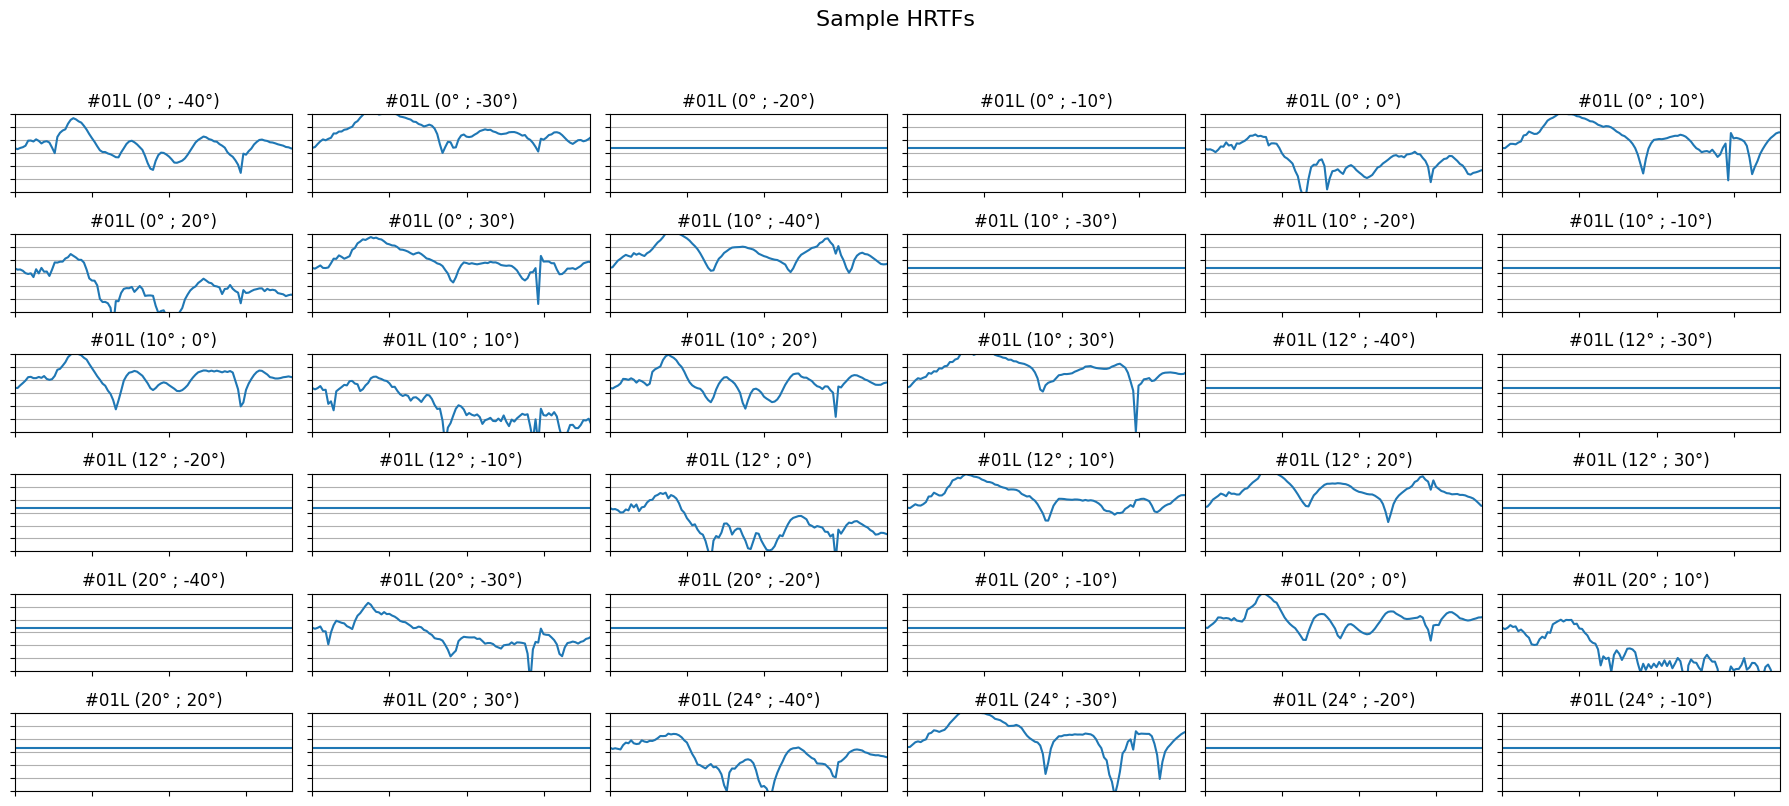

In [10]:
nr, nc = 6, 6
w = 18
h = w / 2.2
f = sio.loadmat('./HRTF data for DL/freq_matlab.mat')['X'][0]
offs = 30

fig, ax = plt.subplots(nr, nc, figsize=(w, h))
for i, a in enumerate(ax.flatten()):
    a.plot(f, x_train[i*100])
    a.set_title('#{:02}{} ({:.0f}° ; {:.0f}°)'.format(
            y_train['id'].iloc[i], y_train['ear'].iloc[i][0].upper(),
            y_train['azimuth'].iloc[i], y_train['elevation'].iloc[i]))    
    a.set_ylim([-1.2, 1.2])
    a.set_xlim([0, 18000])
    a.set_yticks(np.arange(-1.5, 1.51, 0.5))
    a.yaxis.grid()
    a.set_yticklabels([])
    a.set_xticklabels([])
    #a.axis('off')
    print(i)
fig.suptitle('Sample HRTFs', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.94])


## Create network

In [11]:
# network parameters
modelname = 'chen2019'
filters_layers = [256, 192, 128, 96, 64, 48, 32]
n_latent = 16

# create 1d net
encoder, decoder, vae = create_autoencoder_dense(n_input=n_frequencies, 
                                                  filters_layers=filters_layers, 
                                                  n_latent=n_latent,
                                                  gen_plots=True)

# pre-compute some info for training
curr_epoch = 0
log_id = int(time.time()) % 99999999
tensorboard_destination = f'./logs/{log_id}'


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 129)]        0           []                               
                                                                                                  
 encoder_0_dense (Dense)        (None, 256)          33280       ['encoder_input[0][0]']          
                                                                                                  
 encoder_0_bn (BatchNormalizati  (None, 256)         1024        ['encoder_0_dense[0][0]']        
 on)                                                                                              
                                                                                                  
 encoder_0_act (Activation)     (None, 256)          0           ['encoder_0_bn[0][0]']     

FileNotFoundError: [Errno 2] No such file or directory: 'plots/vae_encoder.png'

In [ ]:
print(type(vae))

<class 'keras.engine.functional.Functional'>


## Train network

In [ ]:
# training parameters
batch_size = x_train.shape[0] // 64
print(batch_size)
epochs = 200
validation_freq = 5
earlystopping_patience = -50
checkpoint_destination = None #'./models/{epoch.h5}'
cuda_device = '2'
tqdm_bar = True
# train the autoencoder
epochs_range = [curr_epoch, curr_epoch+epochs]
print(f'Training log: {tensorboard_destination}')
print(f'Training from {epochs_range[0]} to {epochs_range[1]}..')
trainig_history = train_model(vae, x_train, y_train[['azimuth_norm', 'elevation_norm']], 
                              x_test, y_test[['azimuth_norm', 'elevation_norm']], 
                              batch_size, epochs_range=epochs_range,
                              validation_freq=validation_freq,
                              tqdm_bar=tqdm_bar,
                              earlystopping_patience=earlystopping_patience, 
                              checkpoint_destination=checkpoint_destination, 
                              tensorboard_destination=tensorboard_destination, 
                              cuda_device=cuda_device)

curr_epoch += trainig_history.index[-1]

198
Training log: ./logs/77153000
Training from 0 to 200..


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

## Plot results

minimum loss:  0.15714612621391705


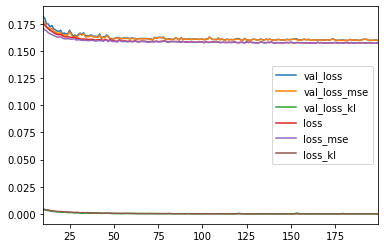

In [ ]:
trainig_history.iloc[10:].plot()
print('minimum loss: ', trainig_history['loss'].min())

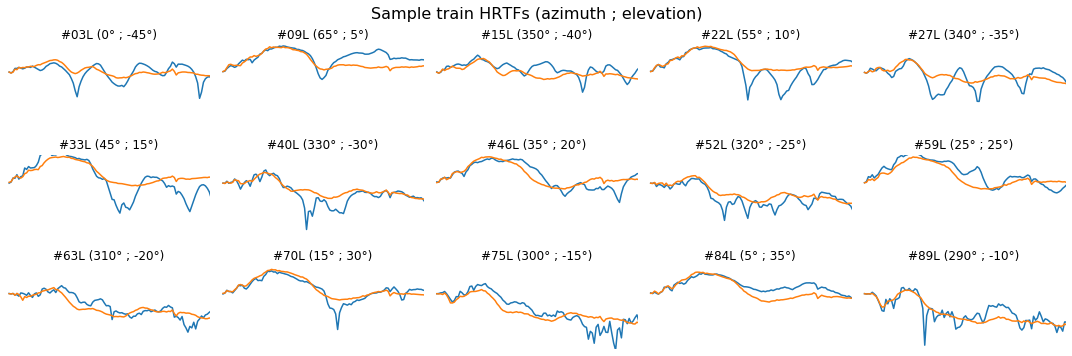

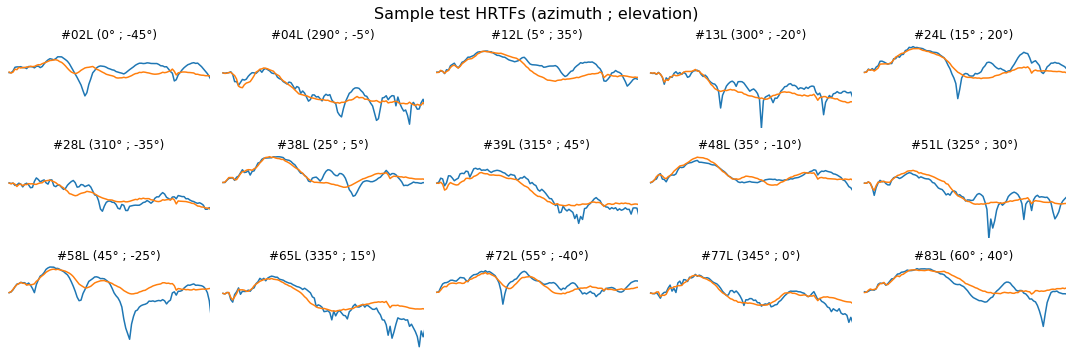

In [90]:
# take data
data_train = (x_train, y_train)
data_test = (x_test, y_test)

# plot reconstructions
fig, axs = plt.subplots(3, 5, figsize=(15, 5))
plot_reconstructions_chen2019(encoder, decoder, data_train, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample train HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

fig, axs = plt.subplots(3, 5, figsize=(15, 5))
plot_reconstructions_chen2019(encoder, decoder, data_test, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample test HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

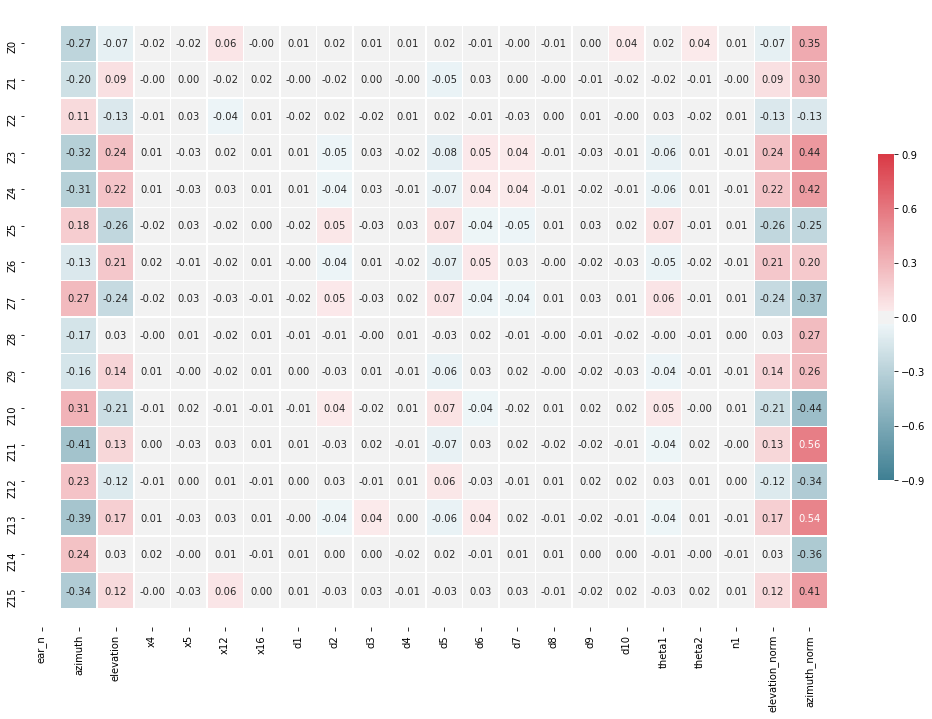

In [91]:
# data to use
drop_cols = ['ear', 'id', 'x6', 'x7', 'x8', 'x9', 'x14', 'x17', 'x2', 'x3', 'x1']
#data_train = (x_train, y_train.drop(columns=['elevation', 'azimuth', 'xoffs', 'yoffs', *drop_cols]).astype(float))
data_train = (x_train, y_train.drop(columns=drop_cols).astype(float))
data_test = (x_test, y_test.drop(columns=drop_cols).astype(float))

# plot correlation
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
corr = plot_xcorr(encoder, data_test, ax,
           batch_size=batch_size, pca=False,
           labels=True)

In [92]:
def spectral_distortion(hrtf_true, hrtf_pred, freqs, f_range):
    fmin, fmax = f_range
    # get bins in range
    f_idx = []
    for i,f in enumerate(freqs):
        if f > fmin and f < fmax:
            f_idx.append(i)
    # formula: sqrt(1/N * sum(square(H_true(f) - H_pred(f))))
    sd_db = np.sqrt((1/len(f_idx)) * np.sum(np.power(hrtf_true[:,f_idx] - hrtf_pred[:,f_idx], 2), axis=1))
    # dB to linear
    #sd = 10 ** (sd_db/20)
    return sd_db

# test
f_range = (3000, 16000)
z_mean, z_log_var = encoder.predict(x_train, batch_size=512)
z_sample = np.concatenate((z_mean, y_train[['azimuth_norm', 'elevation_norm']]), axis=1)
x_pred = decoder.predict(z_sample)

# store SD results
res_train = y_train[['id', 'elevation', 'azimuth']].copy()
res_train['SD'] = spectral_distortion(denormalize_hrtf(x_train, x_train_mean, x_train_std), denormalize_hrtf(x_pred, x_train_mean, x_train_std), freqs, f_range)
print('mean SD (train) = ', res_train['SD'].mean())

mean SD (train) =  5.11019698103282


In [93]:
# test
f_range = (3000, 16000)
z_mean, z_log_var = encoder.predict(x_test, batch_size=512)
z_sample = np.concatenate((z_mean, y_test[['azimuth_norm', 'elevation_norm']]), axis=1)
x_pred = decoder.predict(z_sample)

# store SD results
res_train = y_test[['id', 'elevation', 'azimuth']].copy()
res_train['SD'] = spectral_distortion(denormalize_hrtf(x_test, x_train_mean, x_train_std), denormalize_hrtf(x_pred, x_train_mean, x_train_std), freqs, f_range)
print('mean SD (test)= ', res_train['SD'].mean())

mean SD (test)=  5.16081472782484


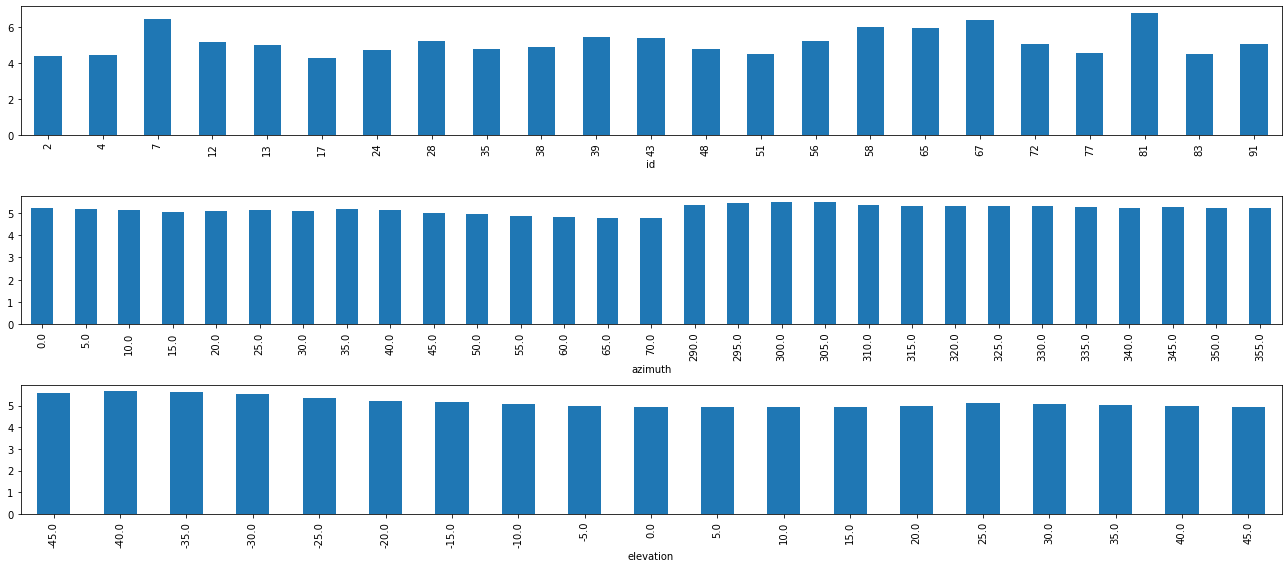

In [94]:
# spectral distortion on train data (various sub-groupings)
fig, axs = plt.subplots(3,1, figsize=(18,8))
res_train.groupby(['id']).mean()['SD'].plot.bar(ax=axs[0])
res_train.groupby(['azimuth']).mean()['SD'].plot.bar(ax=axs[1])
res_train.groupby(['elevation']).mean()['SD'].plot.bar(ax=axs[2])
fig.tight_layout()

/home/rmicci18/miniconda3/envs/hrtf/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


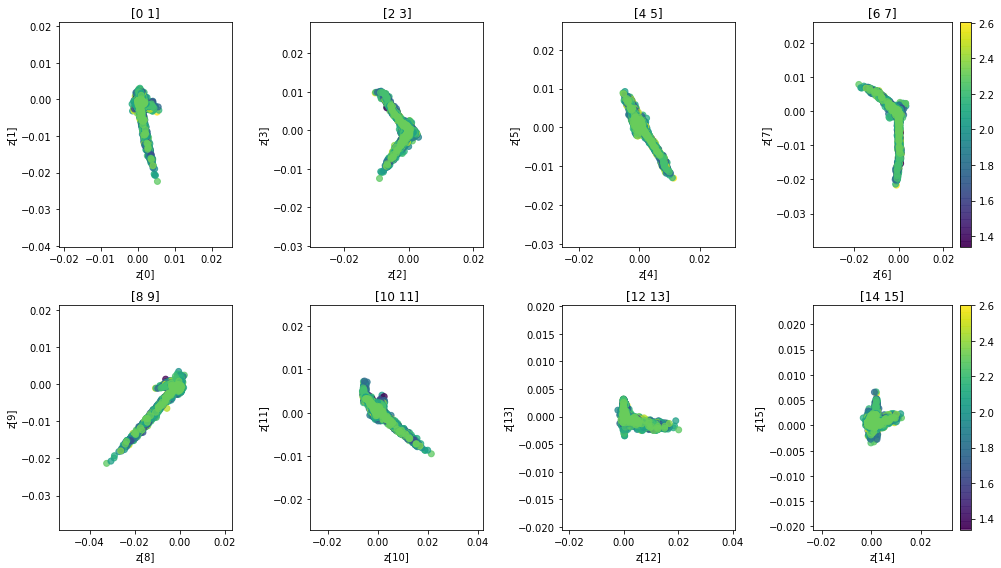

In [95]:
#data_train = (x_train, y_train['id'].astype('category').cat.codes)
#data_test = (x_test, y_test['id'].astype('category').cat.codes)
data_train = (x_train, y_train['d4'])

# plot latent dims
fig, axs = plt.subplots(2, n_latent//4, figsize=(14, 8))
combinations = np.arange(n_latent).reshape((n_latent//2, 2))
for i, dims in enumerate(combinations):
#for dims in [[14, 15]]:
    dims += 0
    plot_latent_space(encoder, data_train, axs.flatten()[i],
                      batch_size=batch_size, dims=dims,
                      colorbar=(i%4==3), use_pca=False)
fig.tight_layout()

In [ ]:
# take data
data_train = (x_train, y_train)
data_test = (x_test, y_test)

# plot reconstructions
fig, axs = plt.subplots(3, 4, figsize=(18, 6))
#plot_reconstructions_chen2019_3d(encoder, decoder, data_train, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample train HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

fig, axs = plt.subplots(3, 4, figsize=(18, 6))
#plot_reconstructions_chen2019_3d(encoder, decoder, data_test, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample test HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

In [ ]:
# plot PC
data_train = (x_train[::2], y_train['azimuth'].iloc[::2])
data_test = (x_test, y_test['elevation'])
plot_latent_pairs(encoder, data_train,
                  batch_size=batch_size, n_pca=False, n_dim=6, plot_kws=dict(edgecolor='none', alpha=0.5, s=15))

In [ ]:
# TODO:
# - 3d plots
# - hyperparam opt: `talos`
# - noise solo a input
# - train con 'cubo' (elevation, azimuth, frequency) https://www.sciencedirect.com/science/article/pii/S0925231215014940
# - semisupervised learning http://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/
# - inception layers (unabridged) https://becominghuman.ai/understanding-and-coding-inception-module-in-keras-eb56e9056b4b
# - plot: tsne on latent space
# - extract hrtf/hrir
# - plot: hrtf/hrir
# - freq_loss: pearson vs mse?
# - store and load trained model

# - spetral distortion (500, 16k) Hz (viking paper)

In [10]:
## NOTE: only run if there's no existing log file!
logs_df = pd.DataFrame(columns=[
    'modelname', 'input_shape', 'filters_layers', 
    'kernel_size', 'n_latent', 'use_batchnorm', 
    'use_maxpool', 'freq_loss', 'date_time'])
logs_df.index.name = 'log_id'
logs_df.to_pickle('./logs_3d.pkl')

